<a href="https://colab.research.google.com/github/CamThustain01/University-Work/blob/main/cmp304_assignment2_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CMP304 Assignment 2 - Emotion Recognition

By Cameron Thustain 1900594




In [ ]:
import dlib

In [ ]:
# get the pre-trained face detection model (need to run only once)
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK
!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2

--2022-05-12 12:15:18--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  42.1MB/s    in 1.4s    

2022-05-12 12:15:20 (42.1 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
# prep face detector objects
datFile = "/content/shape_predictor_68_face_landmarks.dat"
face_detector = dlib.get_frontal_face_detector() # locates faces
lm_extractor = dlib.shape_predictor(datFile) # computes landmarks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
SVC training acc 0.7666666666666667
SVC testing acc 0.19907407407407407
SVC Report               precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.26      0.31      0.29        29
           2       0.19      0.92      0.31        36
           3       0.00      0.00      0.00        27
           4       0.00      0.00      0.00        29
           5       0.00      0.00      0.00        30
           6       1.00      0.03      0.06        32

    accuracy                           0.20       216
   macro avg       0.21      0.18      0.09       216
weighted avg       0.21      0.20      0.10       216

KNN training acc 0.625
KNN test acc 0.25462962962962965
KNN Report               precision    recall  f1-score   support

           0       0.29      0.27      0.28        33
           1   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


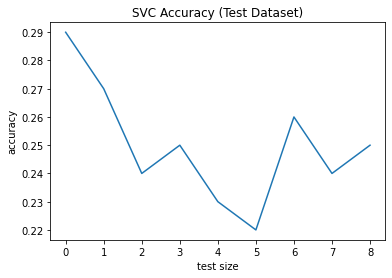

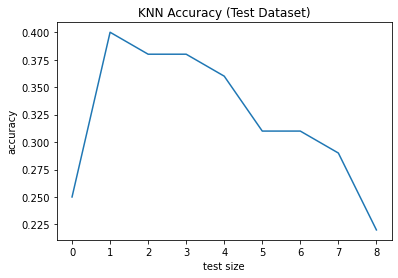

In [ ]:
#libraries and classes imported
from operator import index
import cv2
import csv
import os
import math
from google.colab.patches import cv2_imshow 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn import metrics
import pandas as pd
from pandas import read_csv
from PIL import Image
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np 



        
def dist(p1, p2): # Euclidean distance function 
  x1 = p1.x
  y1 = p1.y
  x2 = p2.x
  y2 = p2.y  
  return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)


def get_features(landmarks, label):
    f_vector = []
    f_vector.append(label)

    #leyebrow length
    eb_x = landmarks.part(17).x
    eb_x1 = landmarks.part(26).x

    #length of eyebrow
    eb_widthDiff = eb_x1 - eb_x

    #lip length
    lip_x = landmarks.part(48).x
    lip_x1 = landmarks.part(54).x

    #length of lip
    liplwidthDiff = lip_x1 - lip_x

    #lip height landmark
    lip_y = landmarks.part(51).y
    l_y = landmarks.part(57).y

    #lip height
    liph_heightDiff = l_y - lip_y

      #append vector             #rows in csv
    f_vector.append(dist(landmarks.part(37), landmarks.part(41)))#A #left eye distance                   #1
    f_vector.append(dist(landmarks.part(44),landmarks.part(46)))#B #right eye distance                   #2
    f_vector.append(dist(landmarks.part(57),landmarks.part(66)))#C #middle of lip distance               #3
    f_vector.append(eb_widthDiff)#D #eyebrow length                                                      #4
    f_vector.append(liplwidthDiff)#E #lip length                                                         #5
    f_vector.append(liph_heightDiff)#F #lip height                                                       #6
   #f_vector.append(dist(landmarks.part(37),landmarks.part(19)))#G # left eye to left eyebrow dist       #7
   #f_vector.append(dist(landmarks.part(44),landmarks.part(24)))#H # right eye to right eyebrow dist     #8

     

    return f_vector
      

def extract(file_path, label): #landmark extraction
    datFile = "/content/shape_predictor_68_face_landmarks.dat"

#setup face detector and landmark extractor
    face_detector = dlib.get_frontal_face_detector()
    lm_extractor = dlib.shape_predictor(datFile)

    csv_path = '/content/drive/MyDrive/cmp304_lab10/features.csv' #training
    csv_path2 = '/content/drive/MyDrive/cmp304_lab10/testfeatures.csv' #testing csv wont write
   
   #pre processing
    csv_path2 = cv2.resize(file_path, (640, 480)) #for resizing the test dataset as images are very small 
    #loop over the faces within the file 
    faces = face_detector(file_path)
    for face in faces:
        f_vector = []
        landmarks = lm_extractor(file_path, face)
        f_vector = get_features(landmarks, label)

#write the csv 
        if not os.path.exists(csv_path):
            with open(csv_path, 'w', newline='') as csvfile:
              #write rows with feature labels at data
              writer = csv.writer(csvfile)
              writer.writerow(['label','leye dist','reye dist','mlip dist','eyebrow len','lip length','lip height'])#,'leye_to_leb','reye_to_reb'])
              writer.writerow(f_vector)
        else:
            with open(csv_path, 'a', newline='') as csvfile:
              writer = csv.writer(csvfile)
              writer.writerow(f_vector)


def train():  
  df = read_csv('/content/drive/MyDrive/cmp304_lab10/features.csv') #training 
  td = read_csv('/content/drive/MyDrive/cmp304_lab10/testfeatures.csv') #testing csv that wont write

##pre processing for model
  y = df['label'] 
  x = df.drop('label', axis=1) 
  y = preprocessing.LabelEncoder().fit_transform(y)

##training mdodel with cohn kanade
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9, random_state=42)
  clf = SVC(kernel='linear', C=1.0) # c is regularization 
  clf.fit(x_train, y_train)
  print('SVC training acc', clf.score(x_train, y_train)) ##prints training accuracy of svm


##testing model with test dataset
  y = td['label']
  x = td.drop('label', axis=1)
  y = preprocessing.LabelEncoder().fit_transform(y)
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9, random_state=42)

  y_pred = clf.predict(x_test)
  print('SVC testing acc', metrics.accuracy_score(y_test, y_pred))

 #SVC Classification Report
  print('SVC Report',classification_report(y_test, y_pred))

  ##K NEAREST NEIGHBOUR CODE
  #testing and train the knn model
  nearest_neighbour_model = KNeighborsClassifier(n_neighbors=3)
  nearest_neighbour_model.fit(x_train,y_train)
  ##print accuracys 
  print('KNN training acc', nearest_neighbour_model.score(x_train,y_train))
  print('KNN test acc', nearest_neighbour_model.score(x_test,y_test))

  #KNN Classification Report
  print('KNN Report',classification_report(y_test, nearest_neighbour_model.predict(x_test)))

  ##arrays for accuracies from test size 0.1 to 0.9
  svc_test_precision = np.array([0.29, 0.27, 0.24, 0.25, 0.23, 0.22, 0.26, 0.24, 0.25])
  knn_test_precision = np.array([0.25, 0.40, 0.38, 0.38, 0.36, 0.31, 0.31, 0.29, 0.22])

#plots graphs 
  plt.plot(svc_test_precision)
  plt.xlabel('test size')
  plt.ylabel('accuracy')
  plt.title('SVC Accuracy (Test Dataset)')
  plt.show()
 
  plt.plot(knn_test_precision)
  plt.xlabel('test size')
  plt.ylabel('accuracy')
  plt.title('KNN Accuracy (Test Dataset)')
  plt.show()



def main():
  from google.colab import drive
  drive.mount('/content/drive') #mounts to google drive 
  dataset = '/content/drive/MyDrive/cmp304_lab10/Cohn-Kanade-Images/' #training 
  testdataset = '/content/drive/MyDrive/cmp304_lab10/Test-Dataset/' #testing dataset that csv wont write


  

  #For Extracting CSV (training & testing dataset) COMMENTED OUT IF CSV HAS ALREADY BEEN CREATED
  ######################################################
  #for folder in os.listdir(testdataset):
   #for image in os.listdir(testdataset + '/' + folder):
    #image = cv2.imread(testdataset + '/' + folder + '/' + image)
    #extract(image, folder)
  ########################################################



  train()#calls train method

  

main()#calls main method


